# RNN Modelling
- Data
    - Domain 1
    - Domain 2
    - Domain 1 & 2

- Data Processing
    - Sequence

- Parameters
    - Learning rate: 0.0001
    - Threshold: 0.5

- Validation
    - cross validation
    
- Visualisation
    - Accuracy Graph
    - Confusion Matrix
    - ROC


## preprocess

In [54]:
from google.colab import drive

# Read data from Google Drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [55]:
import json
import numpy as np
import  tensorflow as tf
import keras
from keras import layers

In [56]:
# imbalanced learning
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [57]:
text = []
label = []
GOOGLE_DRIVE = False

if GOOGLE_DRIVE:
    d1_path = "drive/MyDrive/data/domain1_train.json"
    d2_path = "drive/MyDrive/data/domain2_train.json"
    test_path = "drive/MyDrive/data/test_set.json"
else:
    d1_path = "../../data/domain1_train.json"
    d2_path = "../../data/domain2_train.json"
    test_path = "../../data/test_set.json"    

# 0 machine model1, 1 human
with open(d1_path) as f:
    for line in f:
        # read line by line
        data = json.loads(line)

        # add values
        text.append(data["text"])
        label.append(data["label"])

# 2-8 machine 9 human
with open(d2_path) as f:
    for line in f:
        # read line by line
        data = json.loads(line)

        # add values
        text.append(data["text"])
        if "model" in data.keys():
            label.append(data["model"]+2)
        else:
            label.append(9)

In [58]:
from sklearn.model_selection import train_test_split

# Parameters
SEQUENCE_LENGTH = 200
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 256
OUTPUT_SIZE = 2  # binary classification
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0001

# Padding for the fixed length data
X = tf.keras.utils.pad_sequences(text, padding="post", maxlen=SEQUENCE_LENGTH, value=5000)
y = np.array(label).ravel()

print("Shape of X:", X.shape)
print("Shape of y", y.shape)


# Split train and test dataset
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_data, y_data = X, y

# Over sampling to Balance
ros = RandomOverSampler(random_state=0)
sm = SMOTE(random_state=0)

# Under sampling to balance
rus = RandomUnderSampler(random_state=0)

# Balance between models
X_data, y_data = ros.fit_resample(X_data, y_data)
print("After resampling, Shape of X:", X_data.shape)
print("After resampling, Shape of y", y_data.shape)

Shape of X: (34400, 200)
Shape of y (34400,)
After resampling, Shape of X: (97500, 200)
After resampling, Shape of y (97500,)


In [59]:
# Balance between labels

for i in range(len(y_data)):
    if y_data[i] == 1 or y_data[i] == 9:
        y_data[i] = 1
    else:
        y_data[i] = 0

X_data, y_data = rus.fit_resample(X_data, y_data)
print("After resampling, Shape of X:", X_data.shape)
print("After resampling, Shape of y", y_data.shape)

X_train, y_train = X_data, y_data

After resampling, Shape of X: (39000, 200)
After resampling, Shape of y (39000,)


In [60]:
for i in range(len(y_test)):
    if y_test[i] == 1 or y_test[i] == 9:
        y_test[i] = 1
    else:
        y_test[i] = 0

In [61]:
from collections import Counter

Counter(y_train)

Counter({0: 19500, 1: 19500})

## RNN build

In [62]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
pos = list(y_train).count(1)
neg = list(y_train).count(0)
total = pos + neg
initial_bias = np.log([pos/neg])

In [63]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=5001,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=False),
    layers.Masking(mask_value=5000),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)#, bias_initializer=initial_bias)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(LEARNING_RATE),
              metrics=METRICS)

In [65]:
history = model.fit(X_train, y_train, epochs=5, validation_steps=5)

Epoch 1/5
1219/1219 [==============================] - 82s 64ms/step - loss: 0.5315 - cross entropy: 2.9716 - Brier score: 1.6764 - tp: 9618.0000 - fp: 1466.0000 - tn: 18034.0000 - fn: 9882.0000 - accuracy: 0.7090 - precision: 0.8677 - recall: 0.4932 - auc: 0.7673 - prc: 0.7885
Epoch 2/5
1219/1219 [==============================] - 76s 62ms/step - loss: 0.4084 - cross entropy: 2.2612 - Brier score: 3.6033 - tp: 13542.0000 - fp: 1599.0000 - tn: 17901.0000 - fn: 5958.0000 - accuracy: 0.8062 - precision: 0.8944 - recall: 0.6945 - auc: 0.8405 - prc: 0.8500
Epoch 3/5
1219/1219 [==============================] - 78s 64ms/step - loss: 0.3448 - cross entropy: 1.8332 - Brier score: 5.5000 - tp: 14802.0000 - fp: 1367.0000 - tn: 18133.0000 - fn: 4698.0000 - accuracy: 0.8445 - precision: 0.9155 - recall: 0.7591 - auc: 0.8742 - prc: 0.8802
Epoch 4/5
1219/1219 [==============================] - 79s 65ms/step - loss: 0.3042 - cross entropy: 1.5545 - Brier score: 6.9216 - tp: 15485.0000 - fp: 1312.000

In [66]:
tp = history.history['tp'][-1]
fp = history.history['fp'][-1]
tn = history.history['tn'][-1]
fn = history.history['fn'][-1]
acc = history.history['accuracy'][-1]


In [67]:
model.evaluate(X_test, y_test, verbose=2)

215/215 - 4s - loss: 0.3107 - cross entropy: 1.2978 - Brier score: 11.5112 - tp: 2286.0000 - fp: 619.0000 - tn: 3870.0000 - fn: 105.0000 - accuracy: 0.8948 - precision: 0.7869 - recall: 0.9561 - auc: 0.9257 - prc: 0.8049 - 4s/epoch - 19ms/step


[0.310682475566864,
 1.297810435295105,
 11.511202812194824,
 2286.0,
 619.0,
 3870.0,
 105.0,
 0.8947674632072449,
 0.786919116973877,
 0.9560853242874146,
 0.9257307052612305,
 0.8048774003982544]

## ROC

215/215 [==============================] - 4s 15ms/step


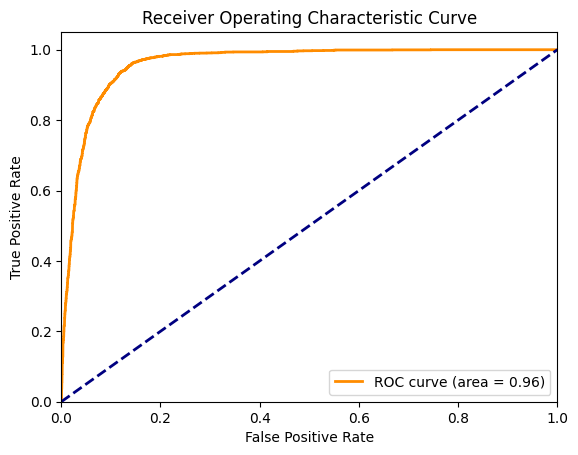

Thresholds: [ 8.6748     7.6748     6.4877777 ... -5.248873  -5.2492943 -5.8899207]


In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Draw ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
print("Thresholds:",thresholds)

In [69]:
import pandas as pd
import os

# Record on csv
df = pd.DataFrame({
    'n_sequences': [SEQUENCE_LENGTH], 
    'Learning_rate': [LEARNING_RATE], 
    '5-fold_cv_score': [acc],
    'tn': [tn],
    'fp': [fp],
    'fn': [fn],
    'tp': [tp]
    })
path = "./RNN_Records.csv"
exists= not os.path.exists(path)
df.to_csv(path, index=False, header=exists, mode='a')


## process testing data

In [19]:
text = []

with open(test_path) as f:
    for line in f:
        # read line by line
        data = json.loads(line)

        # add values
        text.append(data["text"])

texts = tf.keras.utils.pad_sequences(text, padding="post", maxlen=SEQUENCE_LENGTH, value=5000)
y = np.array(label).ravel()

print("Shape of texts:", texts.shape)

Shape of texts: (1000, 200)


In [28]:
# Predict test data

predictions = model.predict(texts)


32/32 [==============================] - 2s 53ms/step


In [51]:
# Adjust prediction for controlling the bias
threshold = 0
predicted_class = (predictions >= threshold).astype(int)

list(predicted_class.flatten()).count(1)

464

In [27]:
import csv

# Create the desired output format
predictions = list(predicted_class.flatten())
output = []
for idx, pred_class in enumerate(predictions):
    output.append({'id': idx, 'class': pred_class})

# Save to CSV
with open('./result_RNN_predictions-II.csv', 'w', newline='') as csvfile:
    fieldnames = ['id', 'class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in output:
        writer.writerow(row)